# DOG BREED CLASSIFICATION
# Context
The Stanford Dogs dataset contains images of 120 breeds of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization. It was originally collected for fine-grain image categorization, a challenging problem as certain dog breeds have near identical features or differ in colour and age.

# Content
* Number of categories: 120
* Number of images: 20,580
* Annotations: Class labels, Bounding boxes

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!kaggle datasets download -d harshadpawar/the-stanford-dogs-dataset

 98% 734M/751M [00:04<00:00, 147MB/s]
100% 751M/751M [00:05<00:00, 156MB/s]


In [4]:
#unzipping the dataset 
import zipfile
zip_ref = zipfile.ZipFile('/content/the-stanford-dogs-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

# Importing necessary libraries

In [5]:
import pickle 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras 
%matplotlib inline 
from pylab import rcParams
from keras.models import Sequential ,load_model
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback,EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix,classification_report
from skimage.transform import resize
import cv2
import seaborn as sns
import os,sys
import imghdr

# Finding all Images inside directory and their labels

In [9]:
import os
import glob

# set the path to the main folder
main_folder_path = "/content/images/Images"

# get all subfolders within the main folder
subfolders = [f.path for f in os.scandir(main_folder_path) if f.is_dir()]

# iterate over each subfolder and get all image files
image_files = []
labels=[]
for subfolder in subfolders:
    # set the path to the subfolder
    subfolder_path = os.path.join(main_folder_path, subfolder)
    # use glob to get all image files within the subfolder
    image_files.extend(glob.glob(os.path.join(subfolder_path, "*.jpg")))

for i in range  (0,len(image_files)):
    segments = image_files[i].split('/')
  # Access the segment containing "Japanese_spaniel"
    segment = segments[-2]

  # Split the segment to extract the term "Japanese_spaniel"
    labels.append(segment.split('-')[1])
   

# print the list of image file paths
print(image_files)
print(len(image_files))


['/content/images/Images/n02107574-Greater_Swiss_Mountain_dog/n02107574_1494.jpg', '/content/images/Images/n02107574-Greater_Swiss_Mountain_dog/n02107574_140.jpg', '/content/images/Images/n02107574-Greater_Swiss_Mountain_dog/n02107574_1092.jpg', '/content/images/Images/n02107574-Greater_Swiss_Mountain_dog/n02107574_3270.jpg', '/content/images/Images/n02107574-Greater_Swiss_Mountain_dog/n02107574_3236.jpg', '/content/images/Images/n02107574-Greater_Swiss_Mountain_dog/n02107574_1261.jpg', '/content/images/Images/n02107574-Greater_Swiss_Mountain_dog/n02107574_3289.jpg', '/content/images/Images/n02107574-Greater_Swiss_Mountain_dog/n02107574_481.jpg', '/content/images/Images/n02107574-Greater_Swiss_Mountain_dog/n02107574_2523.jpg', '/content/images/Images/n02107574-Greater_Swiss_Mountain_dog/n02107574_1007.jpg', '/content/images/Images/n02107574-Greater_Swiss_Mountain_dog/n02107574_2383.jpg', '/content/images/Images/n02107574-Greater_Swiss_Mountain_dog/n02107574_1871.jpg', '/content/images/

In [13]:
[name for name in np.unique(labels)]

['Afghan_hound',
 'African_hunting_dog',
 'Airedale',
 'American_Staffordshire_terrier',
 'Appenzeller',
 'Australian_terrier',
 'Bedlington_terrier',
 'Bernese_mountain_dog',
 'Blenheim_spaniel',
 'Border_collie',
 'Border_terrier',
 'Boston_bull',
 'Bouvier_des_Flandres',
 'Brabancon_griffon',
 'Brittany_spaniel',
 'Cardigan',
 'Chesapeake_Bay_retriever',
 'Chihuahua',
 'Dandie_Dinmont',
 'Doberman',
 'English_foxhound',
 'English_setter',
 'English_springer',
 'EntleBucher',
 'Eskimo_dog',
 'French_bulldog',
 'German_shepherd',
 'German_short',
 'Gordon_setter',
 'Great_Dane',
 'Great_Pyrenees',
 'Greater_Swiss_Mountain_dog',
 'Ibizan_hound',
 'Irish_setter',
 'Irish_terrier',
 'Irish_water_spaniel',
 'Irish_wolfhound',
 'Italian_greyhound',
 'Japanese_spaniel',
 'Kerry_blue_terrier',
 'Labrador_retriever',
 'Lakeland_terrier',
 'Leonberg',
 'Lhasa',
 'Maltese_dog',
 'Mexican_hairless',
 'Newfoundland',
 'Norfolk_terrier',
 'Norwegian_elkhound',
 'Norwich_terrier',
 'Old_English_she

In [14]:
classes=['Afghan_hound','African_hunting_dog','Airedale','American_Staffordshire_terrier','Appenzeller','Australian_terrier','Bedlington_terrier','Bernese_mountain_dog','Blenheim_spaniel',
 'Border_collie','Border_terrier','Boston_bull','Bouvier_des_Flandres','Brabancon_griffon','Brittany_spaniel',
 'Cardigan','Chesapeake_Bay_retriever','Chihuahua','Dandie_Dinmont','Doberman','English_foxhound',
 'English_setter','English_springer','EntleBucher','Eskimo_dog','French_bulldog','German_shepherd',
 'German_short','Gordon_setter','Great_Dane','Great_Pyrenees','Greater_Swiss_Mountain_dog','Ibizan_hound',
 'Irish_setter','Irish_terrier','Irish_water_spaniel','Irish_wolfhound','Italian_greyhound','Japanese_spaniel',
 'Kerry_blue_terrier','Labrador_retriever','Lakeland_terrier','Leonberg','Lhasa','Maltese_dog','Mexican_hairless',
 'Newfoundland','Norfolk_terrier','Norwegian_elkhound','Norwich_terrier','Old_English_sheepdog','Pekinese','Pembroke',
 'Pomeranian','Rhodesian_ridgeback','Rottweiler','Saint_Bernard','Saluki','Samoyed','Scotch_terrier','Scottish_deerhound',
 'Sealyham_terrier','Shetland_sheepdog','Shih','Siberian_husky','Staffordshire_bullterrier','Sussex_spaniel','Tibetan_mastiff','Tibetan_terrier','Walker_hound','Weimaraner','Welsh_springer_spaniel',
 'West_Highland_white_terrier','Yorkshire_terrier','affenpinscher','basenji','basset','beagle','black','bloodhound',
 'bluetick','borzoi','boxer','briard','bull_mastiff','cairn','chow','clumber','cocker_spaniel','collie','curly','dhole',
 'dingo','flat','giant_schnauzer','golden_retriever','groenendael','keeshond','kelpie','komondor','kuvasz','malamute',
 'malinois','miniature_pinscher','miniature_poodle','miniature_schnauzer','otterhound','papillon','pug','redbone',
 'schipperke','silky_terrier','soft','standard_poodle','standard_schnauzer','toy_poodle','toy_terrier','vizsla','whippet','wire']

In [15]:
len(classes)

120

It contain 20580 images of different 120 categories of Dogs 

In [7]:
#Setting directory path for main folder of images
data_dir='/content/images/Images'
os.listdir(data_dir)
print(len(os.listdir(data_dir)))

120


In [8]:
images_exists=["jpeg","jpg","png","bmp"]
images_exists[1]

'jpg'

In [16]:
#getting exact images from any particular folder 
os.listdir(os.path.join(data_dir,"n02085620-Chihuahua"))
print(len(os.listdir(os.path.join(data_dir,"n02085620-Chihuahua"))))
print(len(os.listdir(os.path.join(data_dir,"n02085782-Japanese_spaniel"))))
#it states about the images count in each category inside the main folder

152
185


# Removing Dodgy Images:
   
  * Dodgy images :
  
  dodgy images refer to images that are either corrupted or inappropriate for the intended use of the CNN. Dodgy images can include images that are poorly lit, blurry, distorted, or have other issues that make them difficult for the CNN to accurately classify or analyze. Additionally, dodgy images can include images that contain inappropriate content such as violence, hate speech, or nudity, which may be problematic or offensive for users of the CNN

In [17]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in images_exists: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)
#this code is to check either images are valid or not (means checking dodgy images) if it is not valid it will simply remove

# How to read images from directory into numpy array

In [18]:
cv2.imread(os.path.join('images/Images','n02085620-Chihuahua','n02085620_10074.jpg'))

array([[[ 14,   9,  11],
        [ 13,   8,  10],
        [ 11,   6,   7],
        ...,
        [158, 198, 173],
        [146, 186, 161],
        [128, 165, 145]],

       [[ 14,   9,  11],
        [ 13,   8,  10],
        [ 11,   6,   7],
        ...,
        [140, 182, 157],
        [129, 171, 148],
        [120, 161, 140]],

       [[ 13,   8,  10],
        [ 13,   8,  10],
        [ 12,   7,   8],
        ...,
        [103, 151, 125],
        [ 97, 145, 121],
        [ 98, 145, 123]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  6,   6,   6],
        [  6,   6,   6],
        [  6,   6,   6]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  6,   6,   6],
        [  6,   6,   6],
        [  6,   6,   6]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [  7,   7,   7],
        [  7,   7,   7],
        [  7,   7,   7]]

In [19]:
img=cv2.imread(os.path.join('images/Images','n02085620-Chihuahua','n02085620_10074.jpg'))
type(img)
print(img.shape)
img2=cv2.imread(os.path.join('images/Images','n02085620-Chihuahua','n02085620_10131.jpg'))
type(img2)
print(img2.shape)

(500, 333, 3)
(495, 395, 3)


Means every images does not proper and same dimension it varies from images to images

(-0.5, 332.5, 499.5, -0.5)

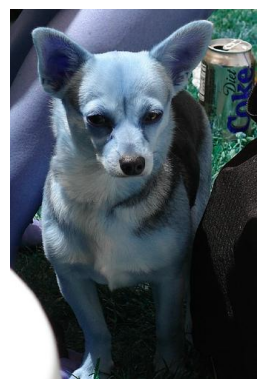

In [20]:
#lets plot randomly 2 images 
plt.imshow(img)
plt.axis("off")

(-0.5, 394.5, 494.5, -0.5)

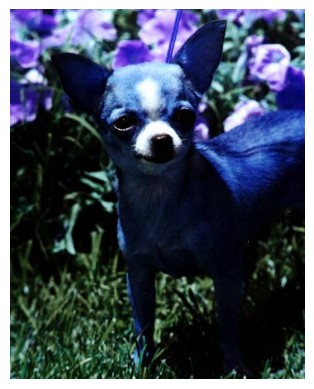

In [21]:
plt.imshow(img2)
plt.axis("off")

Since images are in RGB format but showing like gray scale we have to modify it to display in original format 

(-0.5, 332.5, 499.5, -0.5)

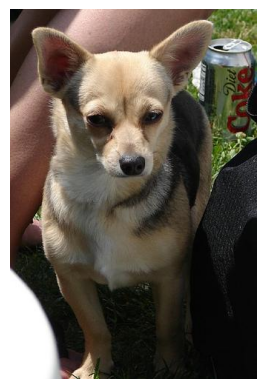

In [22]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB)) #this function convert BGR to RGB format 
plt.axis("off")

(-0.5, 394.5, 494.5, -0.5)

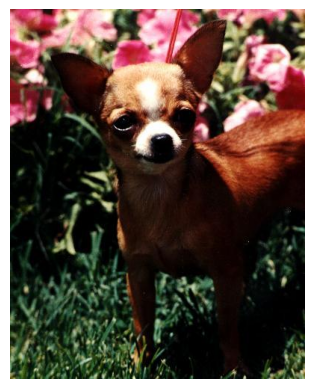

In [23]:
plt.imshow(cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)) #this function convert BGR to RGB format 
plt.axis("off")

# Creating Tensorflow Dataset using tf.keras.utils.image_dataset_from_directory() 

In [47]:
tf.keras.utils.image_dataset_from_directory??

In [26]:
len(labels)

20580

In [63]:
image_data=tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(128,128))
print(image_data)

Found 20580 files belonging to 120 classes.
<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
tf.keras.utils.image_dataset_from_directory??

Since our data is in memory and loaded as generator to access it we have to convert it and load as numpy iterator 

# Load Data 

In [64]:
image_data_iterator=image_data.as_numpy_iterator()

In [65]:
batch1=image_data_iterator.next()
#batch[0] represents the images and batch[1] represents the lables associated with that images

In [66]:
batch1[0]

array([[[[240.99908   , 252.99908   , 251.90533   ],
         [243.63074   , 253.14154   , 251.16315   ],
         [244.36804   , 253.27191   , 250.36804   ],
         ...,
         [219.27972   , 239.10394   , 250.80707   ],
         [218.31158   , 237.31158   , 252.31158   ],
         [217.34344   , 236.34344   , 251.34344   ]],

        [[236.75665   , 247.75665   , 250.54572   ],
         [240.24335   , 250.67029   , 253.38904   ],
         [242.224     , 252.58337   , 253.87958   ],
         ...,
         [221.52142   , 241.34564   , 252.82355   ],
         [221.60272   , 240.60272   , 254.9621    ],
         [220.62799   , 239.62799   , 254.62799   ]],

        [[216.17249   , 226.17249   , 236.70374   ],
         [224.17389   , 234.73315   , 245.1029    ],
         [224.38318   , 237.43378   , 242.97156   ],
         ...,
         [219.78107   , 239.60529   , 251.30841   ],
         [220.        , 239.        , 254.        ],
         [220.        , 239.        , 254.        ]],

In [67]:
batch1[1]

array([  8,  95,  60,  83,  73, 111,  80,  62,  18,  72,  32,  90,  76,
        75, 115, 100,   1,  40,  36,  99,  52,  40,  25,   3,   9,  96,
       113,  86, 114,   2, 114,   9], dtype=int32)

In [68]:
batch1[1][0:5]

array([ 8, 95, 60, 83, 73], dtype=int32)

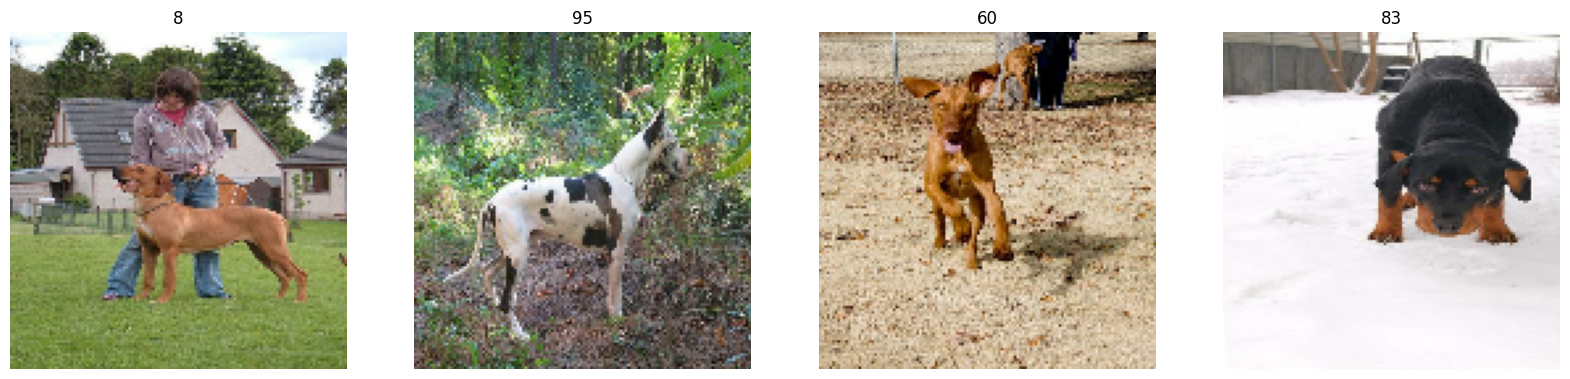

In [69]:
fig,ax=plt.subplots(ncols=4,nrows=1,figsize=(20,20))
for idx,img in enumerate(batch1[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch1[1][idx])
  ax[idx].axis("off")
  


# Rescale the image :     
 
  Since our data is in batch format not necesssary to rescale every time just we have to normalize image size it will rescale all images 

In [ ]:
scaled_image=batch1[0]/255
scaled_image

array([[[[0.58950675, 0.6561734 , 0.5855852 ],
         [0.5865507 , 0.6532174 , 0.58262914],
         [0.58099186, 0.6476585 , 0.5770703 ],
         ...,
         [0.3675682 , 0.38721105, 0.35965505],
         [0.18449755, 0.20509543, 0.1753637 ],
         [0.17314644, 0.20451899, 0.16138174]],

        [[0.54935664, 0.6160233 , 0.5454351 ],
         [0.5772466 , 0.6439133 , 0.57332504],
         [0.60747993, 0.6741466 , 0.60355836],
         ...,
         [0.32610056, 0.34593818, 0.31779784],
         [0.18782169, 0.21162684, 0.17214726],
         [0.1764706 , 0.20784314, 0.16112132]],

        [[0.58094364, 0.6476103 , 0.5770221 ],
         [0.58905786, 0.6557246 , 0.5851363 ],
         [0.6000828 , 0.6667495 , 0.59616125],
         ...,
         [0.2819433 , 0.30459303, 0.26801637],
         [0.18782169, 0.21162684, 0.17199755],
         [0.1764706 , 0.20784314, 0.15686275]],

        ...,

        [[0.07058824, 0.05882353, 0.        ],
         [0.07437193, 0.06260723, 0.0037837 ]

In [ ]:
scaled_image.max()

1.0

# Preprocess the Data 

In [ ]:
batch1[0].shape

(32, 256, 256, 3)

In [ ]:
#Since we have applied rescling manually on batch lets apply on whole dataset 
image_data=image_data.map(lambda x,y : (x/255 ,y ))

In [ ]:
image_data

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
scaled_iterator=image_data.as_numpy_iterator()

In [ ]:
batch=scaled_iterator.next()

In [ ]:
batch[0].max()

1.0

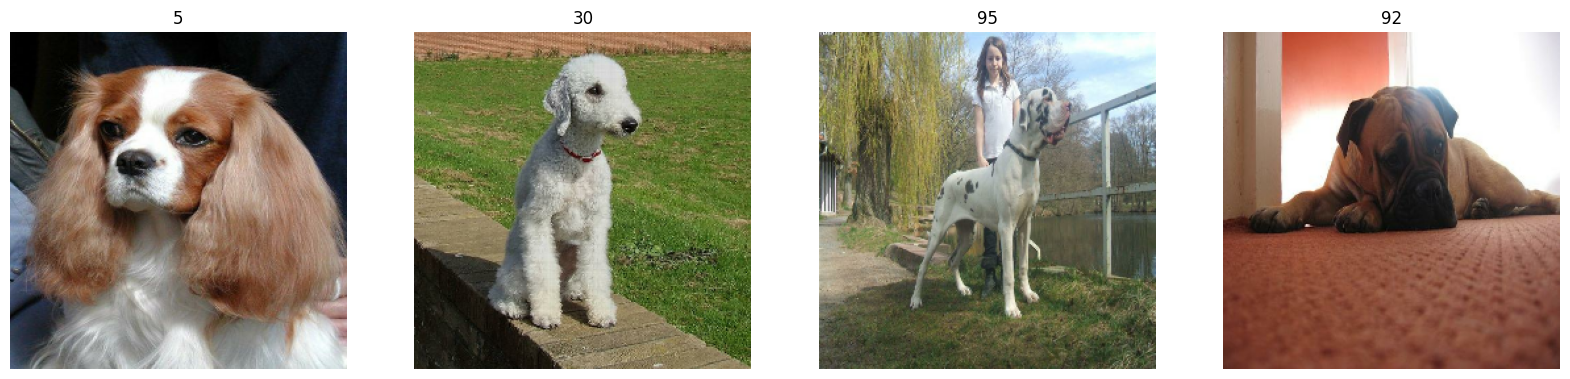

In [ ]:
fig,ax=plt.subplots(ncols=4,nrows=1,figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(batch[1][idx])
  ax[idx].axis("off")
  

# Splitting the dataset :

In [ ]:
train_size=int(len(image_data)*0.7) #training dataset 
val_size=int(len(image_data)*0.2)+1 #validation dataset 
test_size=int(len(image_data)*0.1)+1 #test dataset 

In [ ]:
train_size+val_size+test_size

644

In [ ]:
len(image_data)

644

Since we are using data pipeline to building dataset it has take () and skip() to maintain size of train ,test and validation dataset

In [ ]:
train_set=image_data.take(train_size)
print("trainiing_dataset_size",len(train_set))
validation_set=image_data.skip(train_size).take(val_size)
print("validation_dataset_size",len(validation_set))
test_set=image_data.skip(train_size+val_size).take(test_size)
print("test_dataset_size",len(test_set))

trainiing_dataset_size 450
validation_dataset_size 129
test_dataset_size 65


# Creating Deep Model :

In [ ]:
model=Sequential()

In [ ]:
model.add(Conv2D(16,(3,3),activation='relu',input_shape=(256,256,3))) #useing 3*3 filter and stride of 1 
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dense(256,activation='relu'))

model.add(Dense(120,activation='softmax')) # since it is multiclass classification problem we are using softmax activation function 


In [ ]:
model.compile('adam',loss=tf.losses.CategoricalCrossentropy(),metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 64)      

# Train the Model 

In [ ]:
logdir='/content/logs'

In [ ]:
tensorboard_callbacks=tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist=model.fit(train_set,validation_data=validation_set,epochs=20,callbacks=[tensorboard_callbacks])

Epoch 1/20


ValueError: ignored